In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cxroots

In [2]:
%matplotlib inline

In [3]:
import xwglib as tmm

In [4]:
energy = 14.41

materials = {
    'Pt' : tmm.XRLMaterial(formula='Pt', color='grey', density=21.45),
    'Ta' : tmm.XRLMaterial(formula='Ta', color='green', density=16.6),
    'B4C' : tmm.XRLMaterial(formula='B4C',color='yellow', density=2.52),
    'C' : tmm.XRLMaterial(formula='C', color='black', density=3.52),
    'Fe' : tmm.XRLMaterial(formula='Fe', color='red', density=7.87),
    'Air' : tmm.ConstMaterial(name='Air', color='white', index=1.0)
}

In [5]:
inner_layers = (
    tmm.Layer(materials['B4C'], 10),
    tmm.Layer(materials['Fe'], 1),
    tmm.Layer(materials['B4C'], 15),
)
layerstack = tmm.LayerStack(materials['Pt'], 
                        inner_layers, 
                        materials['Pt'] )

## modefinder in conformal coordinates

In [6]:
m = tmm.Model(*layerstack.get_parameters(energy=energy), method='conformal', branch=tmm.BranchCut.decaying)
s = tmm.Modefinder(m)

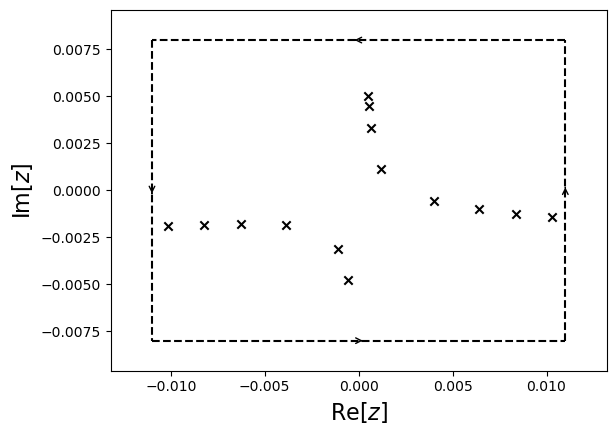

In [7]:
contour = cxroots.Rectangle((-11e-3, 11e-3), (-8e-3, 8e-3))

result, rootresult = s.find_modes(contour)
rootresult.show()

In [8]:
print(result.indices_guided - 1)
print(result.indices_leaky_double - 1)
print(result.indices_other - 1)

[(-3.595798489741675e-06+5.2523824304917803e-08j) --
 (-6.190499505120961e-06+1.4151150071943878e-07j)
 (-1.0726521671666767e-05+3.729566607695588e-07j) --
 (-1.6153671349550258e-05+1.20619304406944e-06j) -- -- -- -- -- -- -- --]
[-- -- -- -- -- -- -- (-2.3840325092616688e-05+4.8580417580930415e-06j) --
 (-3.597227491491939e-05+8.976918062356283e-06j) --
 (-5.030299673081107e-05+1.3068428898133906e-05j) --
 (-6.811383914606672e-05+1.7328358502012477e-05j)]
[-- (-4.92819887409901e-06-9.442037471985884e-08j) -- --
 (-1.1739604839910989e-05-8.455457406101353e-07j) --
 (-2.1786403390677833e-05-4.459462151574815e-06j) --
 (-3.3944606549263234e-05-8.496621058267053e-06j) --
 (-4.806404079149562e-05-1.258714116684803e-05j) --
 (-6.562640654739216e-05-1.67876986253802e-05j) --]


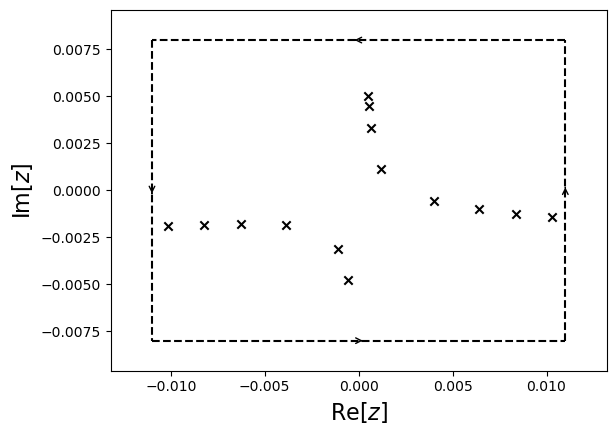

In [9]:
## try the same for TM-polarized modes

result2, rootresult2 = s.find_modes(contour, polarization='TM')
rootresult2.show()

In [10]:
print(result.indices_guided - result2.indices_guided)


[(1.132749449794801e-11-1.7468127240306363e-12j) --
 (3.1175062531474396e-11-5.602004825777358e-12j)
 (4.404832054660801e-11-1.2891376134843377e-11j) --
 (1.0221823387723816e-11-2.941341511165265e-11j) -- -- -- -- -- -- -- --]


In [11]:
# resonance widths in physical energy

print(f'bandwidth: {result.indices_guided[0].imag * energy:.2e} keV')

bandwidth: 7.57e-07 keV


In [12]:
xmin = 1 - 5e-5
xmax = 1

rad, _ = s.radiation_modes(np.linspace(xmin, xmax, 100))
n = s.model.n[1:-1]

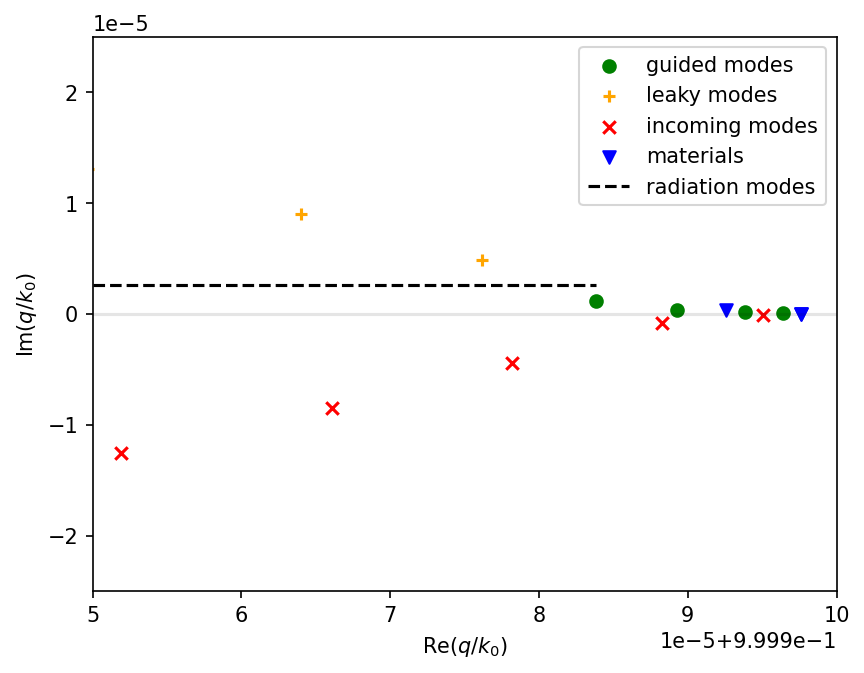

In [13]:
fig, ax = plt.subplots(dpi=150)
ax.scatter(result.indices_guided.real, result.indices_guided.imag, color='green', label='guided modes')
ax.scatter(result.indices_leaky_double.real, result.indices_leaky_double.imag, marker='+', color='orange', label='leaky modes')
ax.scatter(result.indices_other.real, result.indices_other.imag, marker='x', color='red', label='incoming modes')

ax.scatter(n.real, n.imag, marker='v', color='blue', label='materials')
#ax.scatter(n_clad.real, n_clad.imag)
ax.plot(rad.real, rad.imag, ls='--', color='black', label='radiation modes')
ax.axhline(0, color='black', alpha=0.1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(-2.5e-5, 2.5e-5)

#ax.grid()
ax.set_xlabel(r'$\mathrm{Re}(q/k_0)$')
ax.set_ylabel(r'$\mathrm{Im}(q/k_0)$')
ax.legend()
#fig.savefig('modes.png')

## modefinder in fourier coordinates

In [14]:
m2 = tmm.Model(*layerstack.get_parameters(energy=energy), method='fourier', branch=tmm.BranchCut.vertical)
s2 = tmm.Modefinder(m2)

In [15]:
# split the given rectangle into a set of rectangle contours that exclude the vertical branch cuts
# still very crude

branchpoints = (s2.model.n_neg,)
x_range = (1-5e-5,1)
y_range=(-0.1e-5, 1e-5)
contours = tmm.get_contours(branchpoints, x_range=x_range, y_range=y_range, eps=1e-7)


In [16]:
results, rootresults = zip(*[s2.find_modes(c, polarization='TE') for c in contours])
result2 = results[0] + results[1]

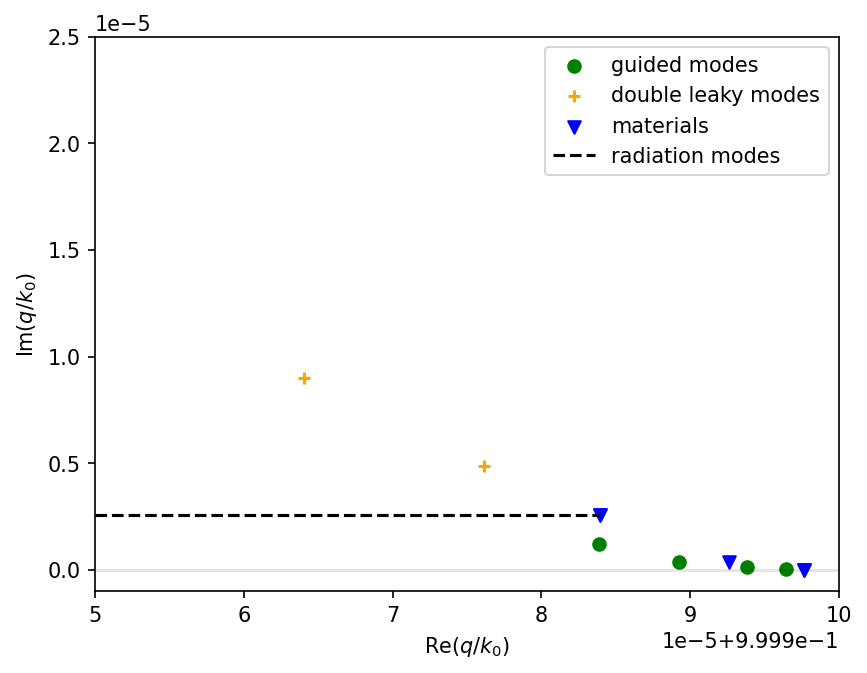

In [17]:
fig, ax = plt.subplots(dpi=150)
ax.scatter(result2.indices_guided.real, result2.indices_guided.imag, color='green', label='guided modes')
ax.scatter(result2.indices_leaky_double.real, result2.indices_leaky_double.imag, marker='+', color='orange', label='double leaky modes')

ax.scatter(m2.n.real, m2.n.imag, marker='v', color='blue', label='materials')
ax.plot(rad.real, rad.imag, ls='--', color='black', label='radiation modes')

#ax.plot(rad_pos.real, rad_pos.imag, ls='--', color='black', label='substrate radiation modes')
#ax.plot(rad_neg.real, rad_neg.imag, ls='-.', color='black', label='superstrate radiation modes')

ax.axhline(0, color='black', alpha=0.1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(-0.1e-5, 2.5e-5)

#ax.grid()
ax.set_xlabel(r'$\mathrm{Re}(q/k_0)$')
ax.set_ylabel(r'$\mathrm{Im}(q/k_0)$')
ax.legend()
#fig.savefig('modes.png')

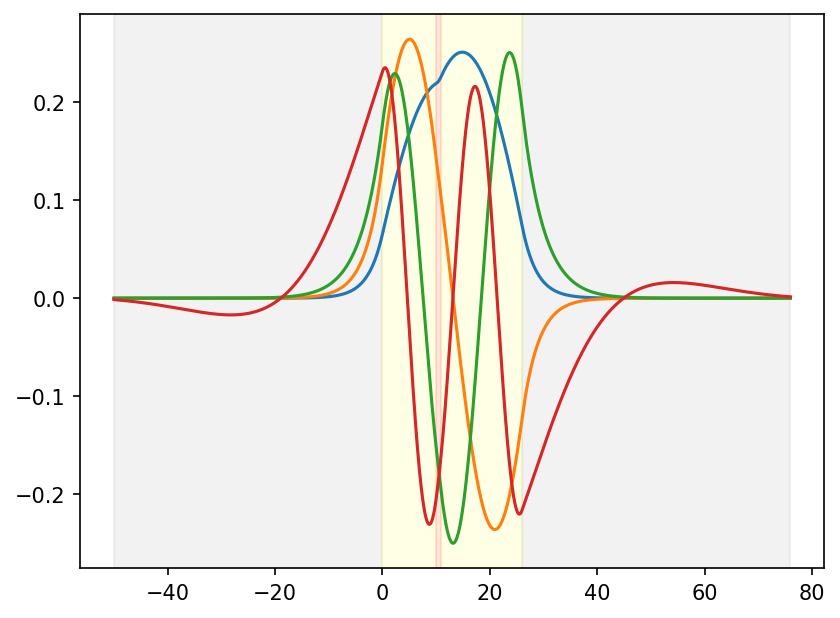

In [18]:
margin = 50
xxx, dx = np.linspace(0-margin, layerstack.get_thickness()+margin, 10000, retstep=True)

fig, ax = plt.subplots(dpi=150)
layerstack.plot_layers(ax, infinity=margin)

for r_ in np.flip(np.sort(result2.indices_guided.compressed())):

    profile0 = s2.solution_neg_te(r_, normalized=True)
    ax.plot(xxx, np.real(profile0(xxx)))



(-5.0, 5.0)

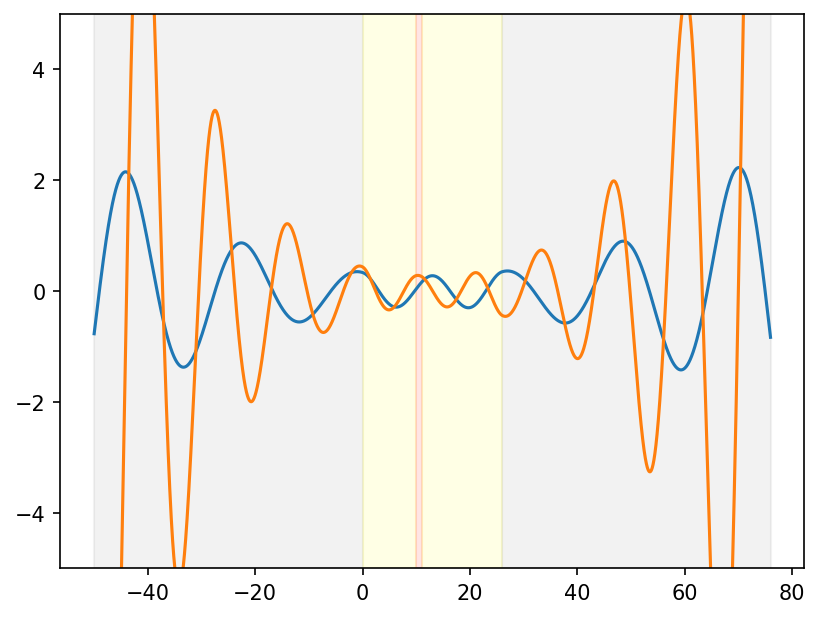

In [19]:
fig, ax = plt.subplots(dpi=150)
layerstack.plot_layers(ax, infinity=margin)

for r_ in np.flip(np.sort(result2.indices_leaky_double.compressed())):
    profile0 = s2.solution_neg_te(r_)
    ax.plot(xxx, np.real(profile0(xxx)))

ax.set_ylim(-5,5)
